In [1]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

## 数据准备

In [2]:
#设置数据文件路径
datapath=r'/Users/nilei/Nutstore/Data/EURUSD_D1.csv'

In [22]:
from dateutil import parser
def getDateTime(s):
    d = parser.parse(s)
    return d
df=pd.read_csv(datapath)
df.index=df['Time (UTC)'].apply(lambda x:getDateTime(x))
old=df.columns[1:]
new=['open','high','low','close','volume']
df=df.rename(columns=dict(zip(old,new)))
df=df.iloc[:,1:]
df['openinterest']=0
df.head()

,open,high,low,close,volume,openinterest
Time (UTC),,,,,,
2010-01-01,1.43283,1.43356,1.43181,1.43335,76787.4,0
2010-01-03,1.43295,1.43359,1.42910,1.43141,6331.3,0
2010-01-04,1.43143,1.44556,1.42559,1.44244,80019.4,0
2010-01-05,1.44238,1.44834,1.43445,1.43634,79887.1,0
2010-01-06,1.43638,1.44342,1.42807,1.44005,80971.8,0


In [16]:
datapath=r'/Users/nilei/Nutstore/Data/EURUSD_D1.csv'         #macos
dt=pd.read_csv(datapath)
dt.rename(columns={'Time (UTC)':'Date'},inplace=True)
dt.index=pd.to_datetime(dt.Date)
dt.drop(columns='Date',inplace=True)
dt.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volume ':'volume'},inplace=True)
dt.head()

,open,high,low,close,volume
Date,,,,,
2010-01-01,1.43283,1.43356,1.43181,1.43335,76787.4
2010-01-03,1.43295,1.43359,1.42910,1.43141,6331.3
2010-01-04,1.43143,1.44556,1.42559,1.44244,80019.4
2010-01-05,1.44238,1.44834,1.43445,1.43634,79887.1
2010-01-06,1.43638,1.44342,1.42807,1.44005,80971.8


In [23]:
import datetime as datetime
data = bt.feeds.PandasData(dataname=df,                               
                            fromdate=datetime.datetime(2019, 1, 1),                               
                            todate=datetime.datetime(2020, 1, 1) )      

## 策略

In [24]:
# Create a Stratey
class MyStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

## 回测框架

In [25]:
def main(startcash,com):
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.addstrategy(MyStrategy)    
    #将数据加载至回测系统
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(bt.sizers.FixedSize,stake=10000)
    print('期初总资金: %.2f' % cerebro.broker.getvalue())    
    cerebro.run()
    portvalue = cerebro.broker.getvalue()
    pnl = portvalue - startcash
    #打印结果
    print(f'总资金：{round(portvalue,2)}')
    print(f'净收益: {round(pnl,2)}')
    cerebro.plot()

期初总资金: 100000.00
2019-01-01, Close, 1.15
2019-01-02, Close, 1.13
2019-01-03, Close, 1.14
2019-01-04, Close, 1.14
2019-01-06, Close, 1.14
2019-01-07, Close, 1.15
2019-01-08, Close, 1.15
2019-01-09, Close, 1.16
2019-01-10, Close, 1.15
2019-01-11, Close, 1.15
2019-01-11, BUY CREATE, 1.15
2019-01-13, BUY EXECUTED, 1.15
2019-01-13, Close, 1.15
2019-01-14, Close, 1.15
2019-01-15, Close, 1.14
2019-01-16, Close, 1.14
2019-01-17, Close, 1.14
2019-01-18, Close, 1.14
2019-01-18, SELL CREATE, 1.14
2019-01-20, SELL EXECUTED, 1.14
2019-01-20, Close, 1.14
2019-01-21, Close, 1.14
2019-01-22, Close, 1.14
2019-01-23, Close, 1.14
2019-01-24, Close, 1.13
2019-01-25, Close, 1.14
2019-01-27, Close, 1.14
2019-01-28, Close, 1.14
2019-01-29, Close, 1.14
2019-01-30, Close, 1.15
2019-01-31, Close, 1.14
2019-02-01, Close, 1.15
2019-02-03, Close, 1.15
2019-02-04, Close, 1.14
2019-02-04, BUY CREATE, 1.14
2019-02-05, BUY EXECUTED, 1.14
2019-02-05, Close, 1.14
2019-02-06, Close, 1.14
2019-02-07, Close, 1.13
2019-02-0

<IPython.core.display.Javascript object>


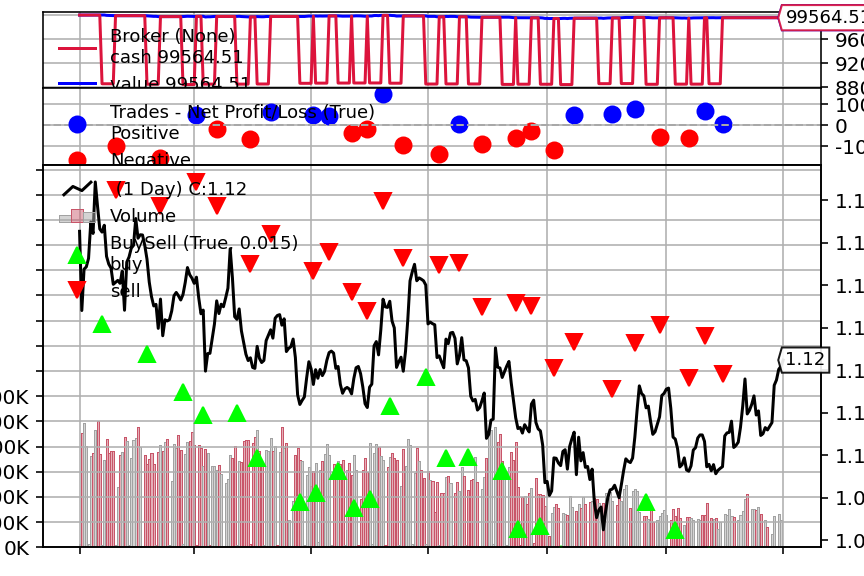

In [26]:
main(100000,0.00001)

## 策略分析

In [27]:
from collections import OrderedDict
def performance(startcash,com):
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.addstrategy(MyStrategy)    
    #将数据加载至回测系统
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(bt.sizers.FixedSize,stake=10000)
        
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.Calmar, _name='_Calmar')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
    cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='_TimeDrawDown')
    cerebro.addanalyzer(bt.analyzers.GrossLeverage, _name='_GrossLeverage')
    cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='_PositionsValue')
    cerebro.addanalyzer(bt.analyzers.LogReturnsRolling, _name='_LogReturnsRolling')
    cerebro.addanalyzer(bt.analyzers.PeriodStats, _name='_PeriodStats')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='_SQN')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='_TradeAnalyzer')
    cerebro.addanalyzer(bt.analyzers.Transactions, _name='_Transactions')
    cerebro.addanalyzer(bt.analyzers.VWR, _name='_VWR')
    
    results = cerebro.run()
    
    performance_dict=OrderedDict()
    calmar_ratio=list(results[0].analyzers._Calmar.get_analysis().values())[-1]
    drawdown_info=results[0].analyzers._DrawDown.get_analysis()
    average_drawdown_len=drawdown_info['len']
    average_drawdown_rate=drawdown_info['drawdown']
    average_drawdown_money=drawdown_info['moneydown']
    max_drawdown_len=drawdown_info['max']['len']
    max_drawdown_rate=drawdown_info['max']['drawdown']
    max_drawdown_money=drawdown_info['max']['moneydown']
    PeriodStats_info=results[0].analyzers._PeriodStats.get_analysis()
    average_rate=PeriodStats_info['average']
    stddev_rate=PeriodStats_info['stddev']
    positive_year=PeriodStats_info['positive']
    negative_year=PeriodStats_info['negative']
    nochange_year=PeriodStats_info['nochange']
    best_year=PeriodStats_info['best']
    worst_year=PeriodStats_info['worst']
    SQN_info=results[0].analyzers._SQN.get_analysis()
    sqn_ratio=SQN_info['sqn']
    VWR_info=results[0].analyzers._VWR.get_analysis()
    vwr_ratio=VWR_info['vwr']
    sharpe_info=results[0].analyzers._SharpeRatio.get_analysis()
    # sharpe_info=results[0].analyzers._SharpeRatio_A.get_analysis()
    sharpe_ratio=sharpe_info['sharperatio']

    performance_dict['calmar_ratio']=round(calmar_ratio*100,3)
    performance_dict['average_drawdown_len']=average_drawdown_len
    performance_dict['average_drawdown_rate']=round(average_drawdown_rate,2)
    performance_dict['average_drawdown_money']=round(average_drawdown_money,2)
    performance_dict['max_drawdown_len']=max_drawdown_len
    performance_dict['max_drawdown_rate']=round(max_drawdown_rate,2)
    performance_dict['max_drawdown_money']=round(max_drawdown_money,2)
    performance_dict['average_rate']=round(average_rate,2)
    performance_dict['stddev_rate']=round(stddev_rate,2)
    performance_dict['positive_year']=positive_year
    performance_dict['negative_year']=negative_year
    performance_dict['nochange_year']=nochange_year
    performance_dict['best_year']=round(best_year*100,2)
    performance_dict['worst_year']=round(worst_year*100,2)
    performance_dict['sqn_ratio']=round(sqn_ratio,2)
    performance_dict['vwr_ratio']=round(vwr_ratio,2)
    performance_dict['sharpe_info']=round(sharpe_ratio,2)
    performance_dict['omega']=0

    trade_dict_1=OrderedDict()
    trade_dict_2=OrderedDict()
    trade_info=results[0].analyzers._TradeAnalyzer.get_analysis()
    total_trade_num=trade_info['total']['total']
    total_trade_opened=trade_info['total']['open']
    total_trade_closed=trade_info['total']['closed']
    total_trade_len=trade_info['len']['total']
    long_trade_len=trade_info['len']['long']['total']
    short_trade_len=trade_info['len']['short']['total']
    
    longest_win_num=trade_info['streak']['won']['longest']
    longest_lost_num=trade_info['streak']['lost']['longest']
    net_total_pnl=trade_info['pnl']['net']['total']
    net_average_pnl=trade_info['pnl']['net']['average']
    win_num=trade_info['won']['total']
    win_total_pnl=trade_info['won']['pnl']['total']
    win_average_pnl=trade_info['won']['pnl']['average']
    win_max_pnl=trade_info['won']['pnl']['max']
    lost_num=trade_info['lost']['total']
    lost_total_pnl=trade_info['lost']['pnl']['total']
    lost_average_pnl=trade_info['lost']['pnl']['average']
    lost_max_pnl=trade_info['lost']['pnl']['max']
    
    trade_dict_1['total_trade_num']=total_trade_num
    trade_dict_1['total_trade_opened']=total_trade_opened
    trade_dict_1['total_trade_closed']=total_trade_closed
    trade_dict_1['total_trade_len']=total_trade_len
    trade_dict_1['long_trade_len']=long_trade_len
    trade_dict_1['short_trade_len']=short_trade_len
    trade_dict_1['longest_win_num']=longest_win_num
    trade_dict_1['longest_lost_num']=longest_lost_num
    trade_dict_1['net_total_pnl']=net_total_pnl
    trade_dict_1['net_average_pnl']=net_average_pnl
    trade_dict_1['win_num']=win_num
    trade_dict_1['win_total_pnl']=win_total_pnl
    trade_dict_1['win_average_pnl']=win_average_pnl
    trade_dict_1['win_max_pnl']=win_max_pnl
    trade_dict_1['lost_num']=lost_num
    trade_dict_1['lost_total_pnl']=lost_total_pnl
    trade_dict_1['lost_average_pnl']=lost_average_pnl
    trade_dict_1['lost_max_pnl']=lost_max_pnl
    
    long_num=trade_info['long']['total']
    long_win_num=trade_info['long']['won']
    long_lost_num=trade_info['long']['lost']
    long_total_pnl=trade_info['long']['pnl']['total']
    long_average_pnl=trade_info['long']['pnl']['average']
    long_win_total_pnl=trade_info['long']['pnl']['won']['total']
    long_win_max_pnl=trade_info['long']['pnl']['won']['max']
    long_lost_total_pnl=trade_info['long']['pnl']['lost']['total']
    long_lost_max_pnl=trade_info['long']['pnl']['lost']['max']
    
    short_num=trade_info['short']['total']
    short_win_num=trade_info['short']['won']
    short_lost_num=trade_info['short']['lost']
    short_total_pnl=trade_info['short']['pnl']['total']
    short_average_pnl=trade_info['short']['pnl']['average']
    short_win_total_pnl=trade_info['short']['pnl']['won']['total']
    short_win_max_pnl=trade_info['short']['pnl']['won']['max']
    short_lost_total_pnl=trade_info['short']['pnl']['lost']['total']
    short_lost_max_pnl=trade_info['short']['pnl']['lost']['max']
    
    trade_dict_2['long_num']=long_num
    trade_dict_2['long_win_num']=long_win_num
    trade_dict_2['long_lost_num']=long_lost_num
    trade_dict_2['long_total_pnl']=long_total_pnl
    trade_dict_2['long_average_pnl']=long_average_pnl
    trade_dict_2['long_win_total_pnl']=long_win_total_pnl
    trade_dict_2['long_win_max_pnl']=long_win_max_pnl
    trade_dict_2['long_lost_total_pnl']=long_lost_total_pnl
    trade_dict_2['long_lost_max_pnl']=long_lost_max_pnl
    trade_dict_2['short_num']=short_num
    trade_dict_2['short_win_num']=short_win_num
    trade_dict_2['short_lost_num']=short_lost_num
    trade_dict_2['short_total_pnl']=short_total_pnl
    trade_dict_2['short_average_pnl']=short_average_pnl
    trade_dict_2['short_win_total_pnl']=short_win_total_pnl
    trade_dict_2['short_win_max_pnl']=short_win_max_pnl
    trade_dict_2['short_lost_total_pnl']=short_lost_total_pnl
    trade_dict_2['short_lost_max_pnl']=short_lost_max_pnl

    df00=pd.DataFrame(index=range(len(performance_dict)))
    df01=pd.DataFrame([performance_dict]).T
    df01.columns=['绩效指标值']
    df02=pd.DataFrame([trade_dict_1]).T
    df02.columns=['普通交易指标值']
    df03=pd.DataFrame([trade_dict_2]).T
    df03.columns=['多空交易指标值']
    df00['绩效指标']=df01.index
    df00['绩效指标值']=df01.round(4).values
    df00['普通交易指标']=df02.index
    df00['普通交易指标值']=[round(float(i),4) for i in list(df02['普通交易指标值'])]
    df00['多空交易指标']=df03.index
    df00['多空交易指标值']=[round(float(i),4) for i in list(df03['多空交易指标值'])]
    
    # 账户收益率
    df0=df1=pd.DataFrame([results[0].analyzers._TotalValue.get_analysis()]).T
    df0.columns=['total_value']
    
    # 总的杠杆
    df1=pd.DataFrame([results[0].analyzers._GrossLeverage.get_analysis()]).T
    df1.columns=['GrossLeverage']
    

    # 滚动的对数收益率
    df2=pd.DataFrame([results[0].analyzers._LogReturnsRolling.get_analysis()]).T
    df2.columns=['log_return']
    
    # year_rate
    df3=pd.DataFrame([results[0].analyzers._AnnualReturn.get_analysis()]).T
    df3.columns=['year_rate']
    
    # 总的持仓价值
    df4=pd.DataFrame(results[0].analyzers._PositionsValue.get_analysis()).T
    df4['total_position_value']=df4.sum(axis=1)

    pyfoliozer = results[0].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    return df00,df0,df1,df2,df3,df4

In [28]:
k1,k2,k3,k4,k5,k6=performance(100000,0.00001)

2019-01-01, Close, 1.15
2019-01-02, Close, 1.13
2019-01-03, Close, 1.14
2019-01-04, Close, 1.14
2019-01-06, Close, 1.14
2019-01-07, Close, 1.15
2019-01-08, Close, 1.15
2019-01-09, Close, 1.16
2019-01-10, Close, 1.15
2019-01-11, Close, 1.15
2019-01-11, BUY CREATE, 1.15
2019-01-13, BUY EXECUTED, 1.15
2019-01-13, Close, 1.15
2019-01-14, Close, 1.15
2019-01-15, Close, 1.14
2019-01-16, Close, 1.14
2019-01-17, Close, 1.14
2019-01-18, Close, 1.14
2019-01-18, SELL CREATE, 1.14
2019-01-20, SELL EXECUTED, 1.14
2019-01-20, Close, 1.14
2019-01-21, Close, 1.14
2019-01-22, Close, 1.14
2019-01-23, Close, 1.14
2019-01-24, Close, 1.13
2019-01-25, Close, 1.14
2019-01-27, Close, 1.14
2019-01-28, Close, 1.14
2019-01-29, Close, 1.14
2019-01-30, Close, 1.15
2019-01-31, Close, 1.14
2019-02-01, Close, 1.15
2019-02-03, Close, 1.15
2019-02-04, Close, 1.14
2019-02-04, BUY CREATE, 1.14
2019-02-05, BUY EXECUTED, 1.14
2019-02-05, Close, 1.14
2019-02-06, Close, 1.14
2019-02-07, Close, 1.13
2019-02-08, Close, 1.13
20

In [29]:
k1

,绩效指标,绩效指标值,普通交易指标,普通交易指标值,多空交易指标,多空交易指标值
0,calmar_ratio,NaN,total_trade_num,25.0000,long_num,25.0000
1,average_drawdown_len,302.00,total_trade_opened,0.0000,long_win_num,11.0000
2,average_drawdown_rate,0.45,total_trade_closed,25.0000,long_lost_num,14.0000
3,average_drawdown_money,449.07,total_trade_len,150.0000,long_total_pnl,-435.4858
4,max_drawdown_len,302.00,long_trade_len,150.0000,long_average_pnl,-17.4194
5,max_drawdown_rate,0.59,short_trade_len,0.0000,long_win_total_pnl,603.2513
6,max_drawdown_money,593.04,longest_win_num,3.0000,long_win_max_pnl,145.8759
7,average_rate,-0.00,longest_lost_num,4.0000,long_lost_total_pnl,-1038.7371
8,stddev_rate,0.00,net_total_pnl,-435.4858,long_lost_max_pnl,-156.5271
9,positive_year,0.00,net_average_pnl,-17.4194,short_num,0.0000


In [13]:
k2

,total_value
2012-01-01,100000.00000
2012-01-02,100000.00000
2012-01-03,100000.00000
2012-01-04,100000.00000
2012-01-05,100000.00000
...,...
2019-12-27,91013.22437
2019-12-29,90913.22437
2019-12-30,90913.10625
2019-12-31,90913.10625


In [14]:
k3

,GrossLeverage
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.000000
2012-01-04,0.000000
2012-01-05,0.000000
...,...
2019-12-27,-1.227437
2019-12-29,-1.229887
2019-12-30,0.000000
2019-12-31,0.000000


In [15]:
k4

,log_return
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.000000
2012-01-04,0.000000
2012-01-05,0.000000
...,...
2019-12-27,-0.007673
2019-12-29,-0.001099
2019-12-30,-0.000001
2019-12-31,0.000000


In [16]:
k5

,year_rate
2012,-0.019468
2013,-0.032631
2014,0.106462
2015,0.038086
2016,-0.055957
2017,-0.056486
2018,0.019098
2019,-0.080723
2020,0.000000


In [18]:
type(k5)

pandas.core.frame.DataFrame

In [17]:
k6

,0,total_position_value
2012-01-01,0.0,0.0
2012-01-02,0.0,0.0
2012-01-03,0.0,0.0
2012-01-04,0.0,0.0
2012-01-05,0.0,0.0
...,...,...
2019-12-27,-111713.0,-111713.0
2019-12-29,-111813.0,-111813.0
2019-12-30,0.0,0.0
2019-12-31,0.0,0.0


In [28]:
k6[k6['total_position_value']<0].describe()

,0,total_position_value
count,1276.000000,1276.000000
mean,-118975.902038,-118975.902038
std,9708.653586,9708.653586
min,-138865.000000,-138865.000000
25%,-128326.250000,-128326.250000
50%,-115767.500000,-115767.500000
75%,-111060.750000,-111060.750000
max,-103906.000000,-103906.000000
